一、采用tensorflow + keras 实现视频识别 + NLP 


In [1]:
#导入必要库
import os
import h5py
import tensorflow as tf
import pandas as pd
from tensorflow import keras
from tensorflow.python.keras import layers
from tensorflow.python.keras import applications
from tensorflow.python.keras.applications import inception_v3 as iv
from tensorflow.python.keras.utils import plot_model 
from tensorflow.python.keras import backend as K  
from tensorflow.contrib.learn import learn_runner

import matplotlib.pyplot as plt # plt 用于显示图片
import matplotlib.image as mpimg # mpimg 用于读取图片
import numpy as np
from scipy import misc

/home/conda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# dimensions of our images.  
img_width, img_height = 64, 64  
  
train_data_dir = 'data/train'  
validation_data_dir = 'data/validation'  
nb_train_samples = 2000  
nb_validation_samples = 1000  
epochs = 30  
batch_size = 32  
  
if K.image_data_format() == 'channels_first':  
    input_shape = (3, img_width, img_height)  
else:  
    input_shape = (img_width, img_height, 3)  

In [3]:
#turning frames into a vector whith pre-trained representations 
video = tf.keras.Input(shape = (None,150,150,3),name='video')  #视频输入 分辨率 150 * 150 

In [4]:
cnn = iv.InceptionV3(weights='imagenet',include_top=False,pooling='avg') # 利用InceptionV3构建 卷积神经网络模型 
cnn.trainable = False #设置为不可修改，因为人家经过试验这个权重是最好的，不用再修改
frame_features = layers.TimeDistributed(cnn)(video)  #把视频的全部帧放到时间轴上，便于得到每帧的张量 
video_vector = layers.LSTM(256)(frame_features) #导入LSTM 等到单一的矢量 

In [5]:
#turning a sequence of words into a vector
input_voc_size = 10000  #字典单词数量  
question = keras.Input(shape=[100],dtype='int32',name='question')
embedded_words = layers.Embedding(input_dim = input_voc_size, output_dim=512, input_length=100)(question)
question_vector = layers.LSTM(256)(embedded_words)

In [6]:
#prediction an answer word
output_voc_size = 100
merged = layers.concatenate([video_vector,question_vector])
dense = layers.Dense( 128, activation = tf.nn.relu)(merged)
output = layers.Dense(output_voc_size,activation='softmax',name=None)(dense)


In [7]:
#setting up the tranining configuration 
keras_model = keras.models.Model(inputs=[video,question],outputs=output)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
video (InputLayer)              (None, None, 150, 15 0                                            
__________________________________________________________________________________________________
question (InputLayer)           (None, 100)          0                                            
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, None, 2048)   21802784    video[0][0]                      
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 100, 512)     5120000     question[0][0]                   
__________________________________________________________________________________________________
lstm_1 (LS

/home/conda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  app.launch_new_instance()


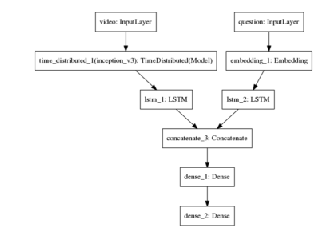

In [9]:
keras_model.compile( optimizer = tf.train.AdamOptimizer(), loss='categorical_crossentropy', metrics=['accuracy'] )

#vq_model.compile( optimizer = tf.train.AdamOptimizer(),
#                   loss = tf.softmax_cross_entropy_with_logits )
#模型训练
#vq_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=69, batch_size=200, verbose=2)

#打印模型概要信息
print(keras_model.summary())
#interpretation model (保存模型网络结构图)
plot_model(keras_model, to_file='tf_keras_multiple_inputs.png')

#读取网络结构图片
png = mpimg.imread('tf_keras_multiple_inputs.png')
#图片缩放
big_png = misc.imresize(png, 0.5 )
#关闭坐标
plt.axis('off') #关闭坐标

#显示图片
plt.imshow(big_png) 


In [85]:
# Leveraging Experiment for distributed training

def experiment_fn( ):         
       
    #模型转换 (keras ---> tensoflow )
    model_dir = os.path.join(os.path.dirname(os.path.abspath('home')), 'train')
    est_model = tf.keras.estimator.model_to_estimator(keras_model, model_dir=model_dir)
    
    #estimator = tf.estimator.Estimator(model_fn = est_model,params = hparams , config = run_config ) 
    #estimator =model.get_estimator(run_config,hparam )
    estimator = est_model
    
    # 下载视频数据集（京东万象）  也可以直接通过其他方式下载，该步骤可省略
    #dataset = tf.keras.utils.get_file( fname="train0001.rar",
    #                                   origin="https://wx.jdcloud.com/market/packet/10465/train0001.rar",
    #                                   extract = True )        
       
    # Setup data loaders---You Tube dataset     
        
    #train_input_fn, train_input_hook = get_train_inputs( hparams.train_batch_size,hparams.dataset_dir,hparams.dataset_file_pattern)    
    #eval_input_fn, eval_input_hook = get_val_inputs( hparams.eval_batch_size,hparams.dataset_dir,hparams.dataset_file_pattern)    
    #training_set = pd.read_csv("boston_train.csv", skipinitialspace=True, skiprows=1, names=COLUMNS)
    #test_set =     pd.read_csv("boston_test.csv", skipinitialspace=True,skiprows=1, names=COLUMNS)
    #prediction_set = pd.read_csv("boston_predict.csv", skipinitialspace=True,skiprows=1, names=COLUMNS)
    
    
    def get_input_fn(data_set, num_epochs=None, shuffle=True):
          return tf.estimator.inputs.pandas_input_fn(
          x=pd.DataFrame({k: data_set[k].values for k in FEATURES}),
          y=pd.Series(data_set[LABEL].values),
          num_epochs=num_epochs,
          shuffle=shuffle)

   
    return tf.contrib.learn.Experiment(
        estimator,
        train_input_fn = get_input_fn(training_set,steps=5000,shuffle=True),
        eval_input_fn =  get_input_fn(testing_set, num_epochs=1, shuffle=False ),                 
        train_steps=hparams.train_steps,  # Minibatch steps
        min_eval_frequency=hparams.eval_min_frequency, # Eval frequency
        eval_steps=hparams.eval_steps)  # Use evaluation feeder until its empty
        #train_monitors=[],  # Hooks for training
        #eval_hooks=[eval_input_hook],  # Hooks for evaluation     
                
                    

if __name__ == '__main__':
    #run_config = tf.contrib.learn.RunConfig(save_checkpoints_secs = 300,keep_checkpoint_max = 3,model_dir ='./mnist_training')
    model_dir = os.path.join(os.path.dirname(os.path.abspath('home')), 'train')
    
    #run_config = tf.contrib.learn.RunConfig(save_checkpoints_secs = 300,keep_checkpoint_max = 3,model_dir=model_dir)    
    run_config = tf.contrib.learn.RunConfig()                                            
    #hparams = tf.contrib.training.HParams(learning_rate=0.002,n_classes=10,train_steps=5000,eval_min_frequency=100)                            
    hparams = tf.contrib.training.HParams( )  
    learn_runner.run(experiment_fn=experiment_fn(), 
                     run_config = run_config,   
                     hparams = hparams,
                     schedule= 'train_and_evaluate')